# Test Ensemble

This notebook classifies the input EDF using the pretrained models.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%cd ..
%load_ext autoreload
%autoreload 2

# Load some packages
import os
from copy import deepcopy
import hydra
from collections import OrderedDict

import numpy as np
import pandas as pd
import pyedflib
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchaudio
from torch.utils.data import DataLoader

import pprint
from tqdm.auto import tqdm
import wandb
import matplotlib
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox

# custom package
from datasets.caueeg_dataset import CauEegDataset
from datasets.caueeg_data_curation import calculate_age, birth_to_datetime
from datasets.pipeline import EegChangeMontageOrder, EegResample
from datasets.pipeline import eeg_collate_fn
from datasets.pipeline import EegNormalizeMeanStd, EegNormalizePerSignal
from datasets.pipeline import EegNormalizeAge
from datasets.pipeline import EegToTensor, EegToDevice
from datasets.pipeline import EegSpectrogram
from datasets.caueeg_script import compose_transforms, compose_preprocess
import models
from train.evaluate import estimate_score
from train.visualize import draw_heatmap, annotate_heatmap

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

num_workers = 0  # A number other than 0 causes an error
pin_memory = True

PyTorch version: 1.12.1+cu113
cuda is available.


---

## Configurations

In [3]:
crop_multiple = 128
test_crop_multiple = 16
repeat = 2
verbose = False

old_montage = ['Fp1-AVG', 'F3-AVG', 'C3-AVG', 'P3-AVG', 'O1-AVG', 'Fp2-AVG', 'F4-AVG', 
               'C4-AVG', 'P4-AVG', 'O2-AVG', 'F7-AVG', 'T3-AVG', 'T5-AVG', 'F8-AVG', 
               'T4-AVG', 'T6-AVG', 'FZ-AVG', 'CZ-AVG', 'PZ-AVG', 'EKG', 'Photic']
old_sample_freq = 200

model_names = [
    '2686pm3p',  # input_norm: datapoint
    'jk7a4cyj',  # input_norm: datapoint
    '2ugdkwu4',  # input_norm: datapoint
    '1rn23vp7',  # input_norm: dataset
    'lo88puq7',  # input_norm: dataset
]
model_pool = []
for model_name in model_names:
    path = os.path.join(r'./local/checkpoint', model_name, 'checkpoint.pt')
    try:
        ckpt = torch.load(path, map_location=device)
        model_pool.append({'name': model_name, 'path': path})
    except Exception as e:
        print(e)
        print(f'- checkpoint cannot be opened: {path}')
        
pprint.pprint([model_dict['name'] for model_dict in model_pool])

# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text
plt.style.use('default') 
plt.rcParams["font.family"] = 'DejaVu Sans' # 'NanumGothic' # for Hangul in Windows
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet' # 'jet', 'nipy_spectral', 'rainbow'

def draw_stft(signals, montage):
    signal = signals
    channels = len(montage)
    columns = 4
        
    fig, ax = plt.subplots(round(np.ceil(channels / columns)), columns, 
                           figsize=(15.0, 12.0), constrained_layout=True)
    
    for k in range(channels):
        Pxx, freqs, bins, im = ax[k // columns, k % columns].specgram(signal[k, :20000], 256, 256)
        ax[k // columns, k % columns].set_title(montage[k], fontsize=12, fontweight='bold', color='darkred')
        ax[k // columns, k % columns].set_xlabel('Time', fontsize=9)
        ax[k // columns, k % columns].set_ylabel('Frequency', fontsize=9)
        
    fig.suptitle('Time-Frequency Representation', fontsize=20, fontweight='semibold')
    plt.tight_layout()
    plt.show()
    plt.close('all')

def error_message(title, message):
    root = tk.Tk()
    root.withdraw()
    root.focus_force()
    root.wm_attributes('-topmost', 1)
    messagebox.showerror(title, message)
    root.destroy()

['2686pm3p', 'jk7a4cyj', '2ugdkwu4', '1rn23vp7', 'lo88puq7']


-----

## Evaluate each model and accumulate the logits

Selected EDF: C:/Users/Minjae/Desktop/EEG_NEW_DEVICE/01576217~ Kang_91eb03f2-9af6-41cc-bca6-01b90f16c4e9.EDF
Loaded EDF signal has the shape of : (20, 231680)



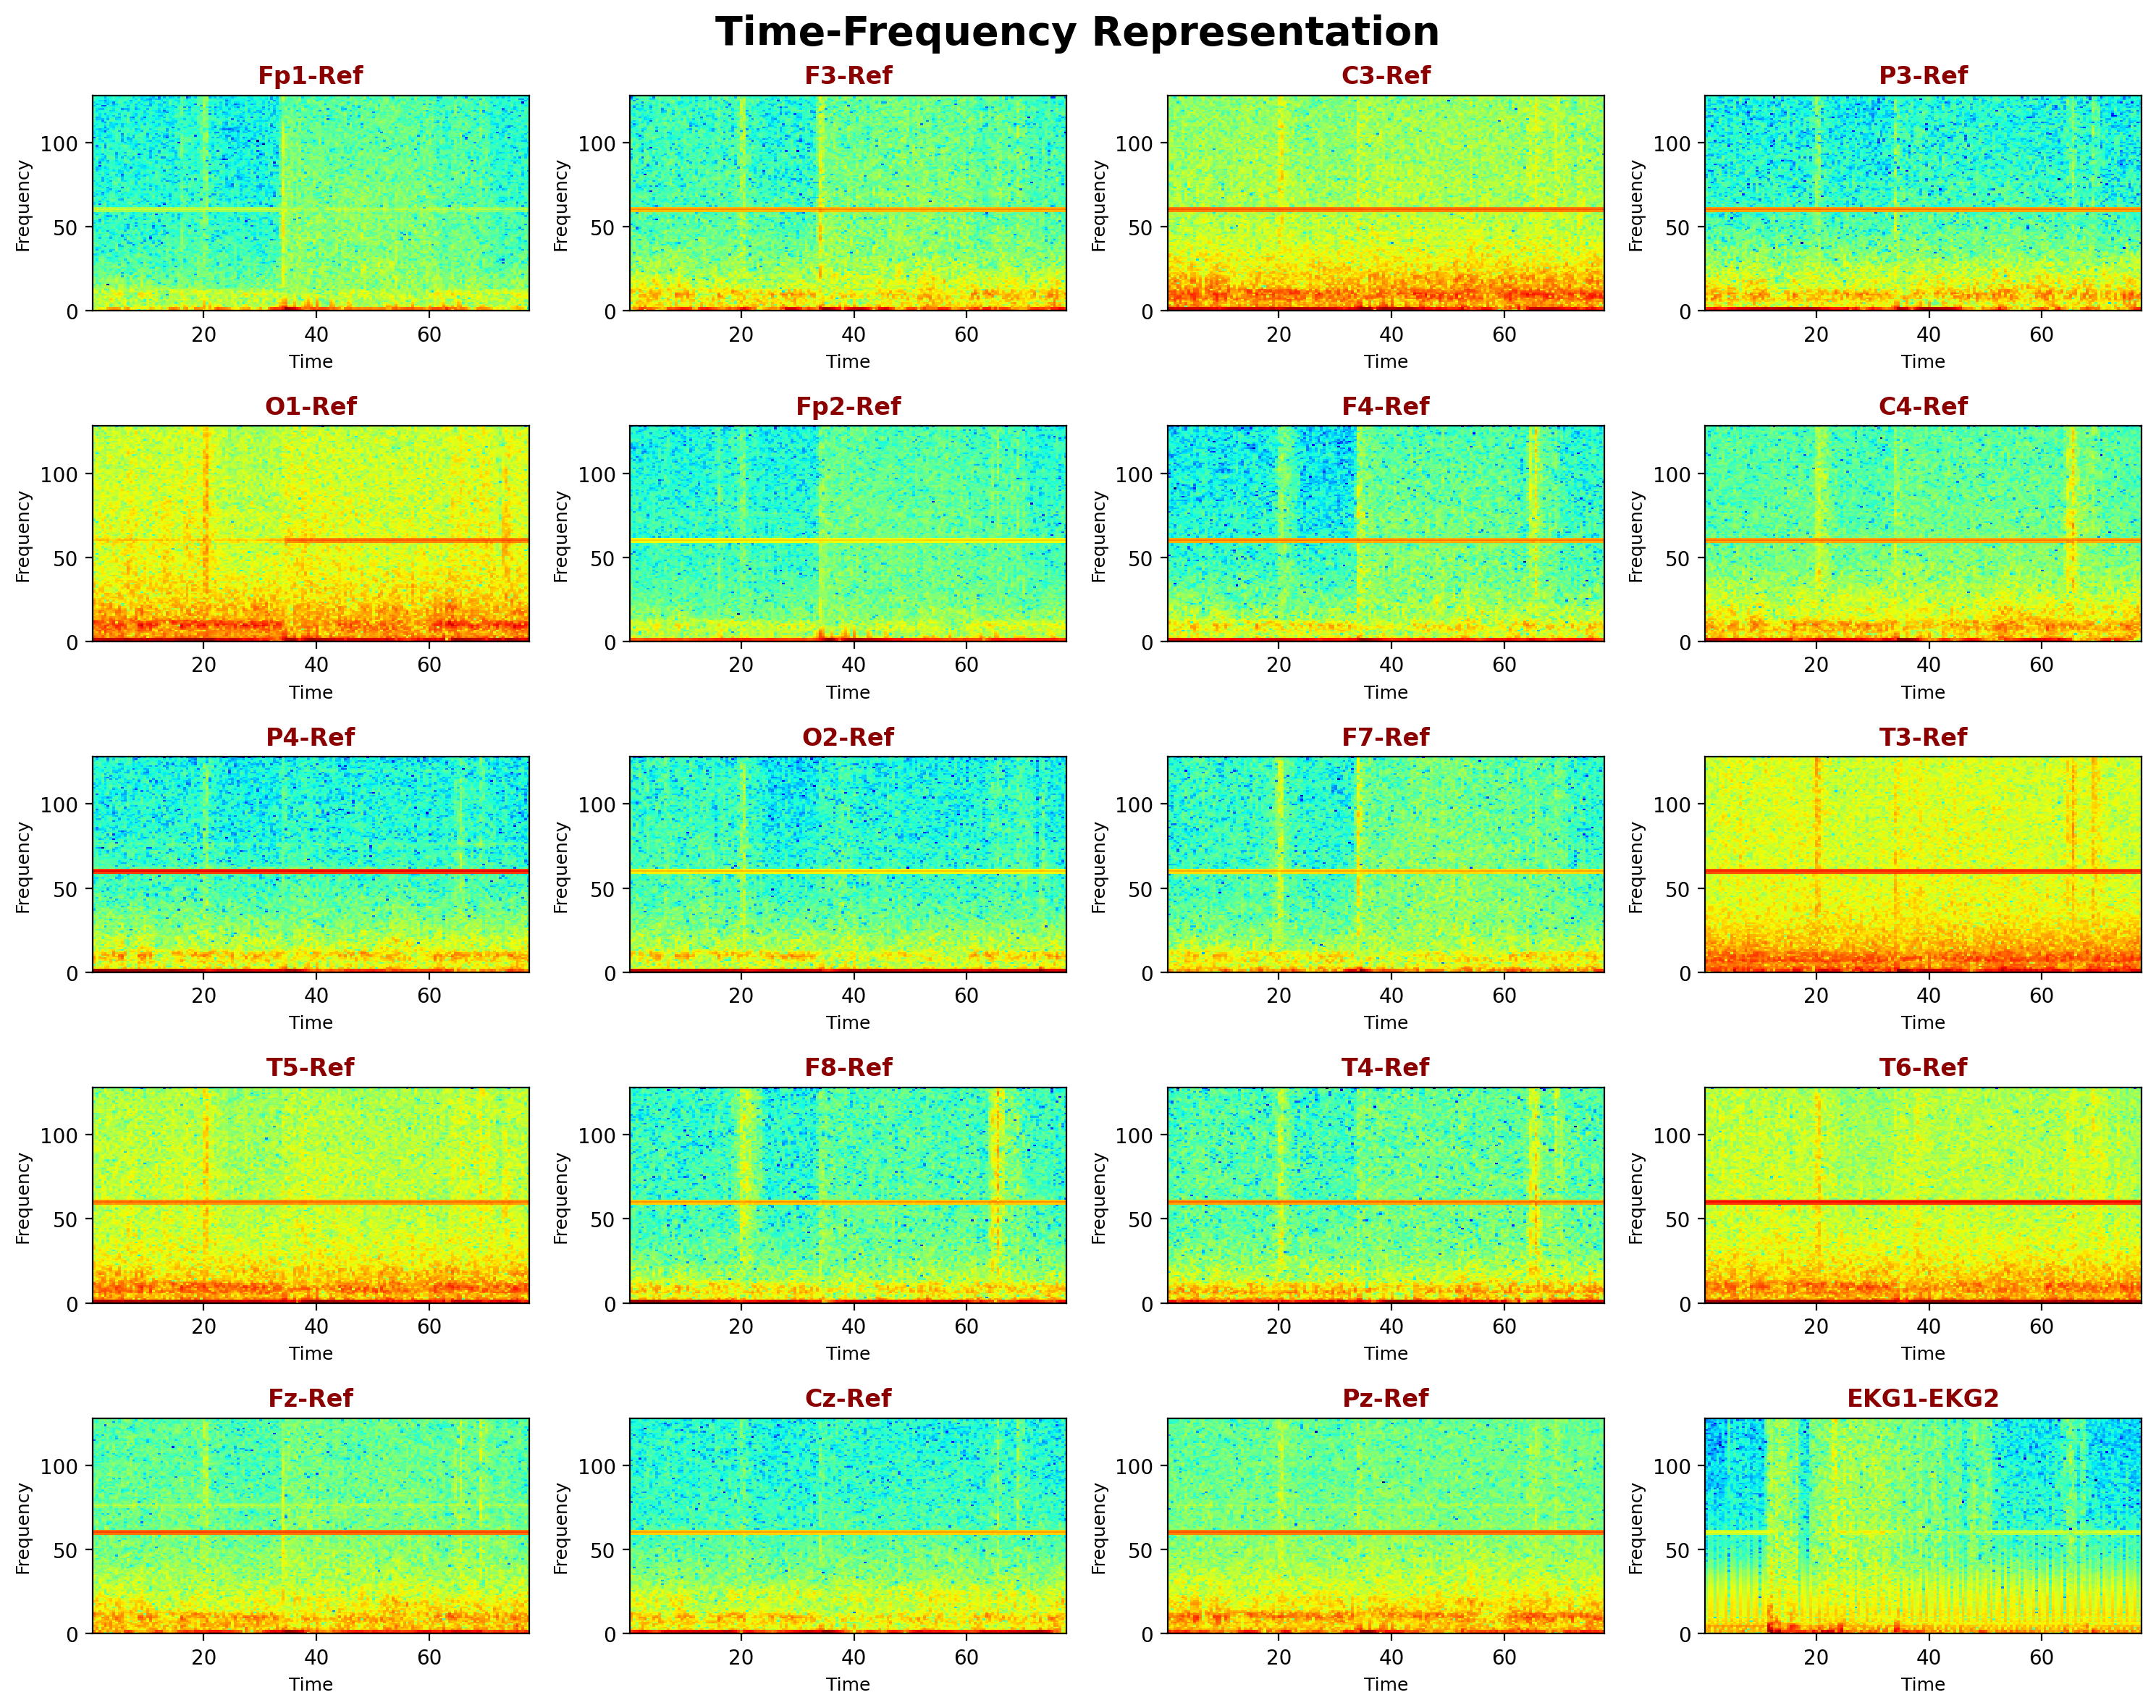

  0%|          | 0/5 [00:00<?, ?it/s]

- checking for 2686pm3p model...
- checking for jk7a4cyj model...
- checking for 2ugdkwu4 model...
- checking for 1rn23vp7 model...
- checking for lo88puq7 model...

==== Estimated Score: ====

- <  Normal  > score: 	 5.46 %
- <   MCI    > score: 	48.66 %
- < Dementia > score: 	45.88 %



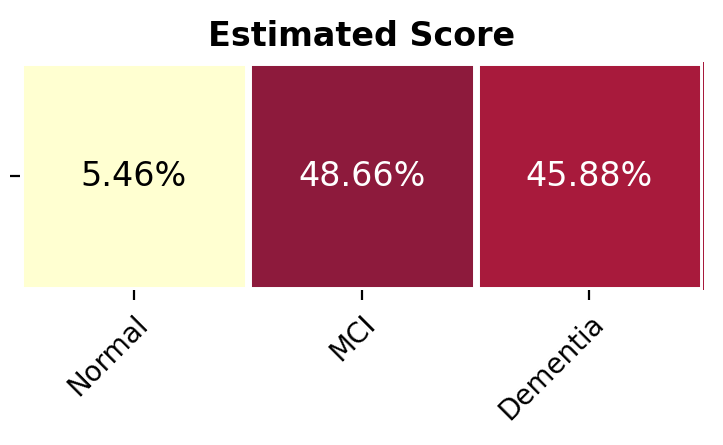

In [13]:
# file picker: EDF
root = tk.Tk()
root.withdraw()
root.focus_force()
root.wm_attributes('-topmost', 1)
edf_file = filedialog.askopenfile(title="Select an EDF file",
                                  filetypes=(("EDF files", "*.edf"),
                                             ("all files", "*.*"))).name
print("Selected EDF:", edf_file)
root.destroy()

# read the EDF file
signals, signal_headers, edf_header = pyedflib.highlevel.read_edf(edf_file)
print("Loaded EDF signal has the shape of :", signals.shape)
print()

# calculate age
if edf_header['birthdate'] != '':
    birth = datetime.datetime.strptime(edf_header['birthdate'], "%d %b %Y")
    age = calculate_age(birth, edf_header['startdate'])
else:
    error_message('Error', 'Cannot parse the patients age..')
    raise ValueError('ERROR: Cannot parse the patients age..')

# sampling frequency
new_sample_freq = signal_headers[0]['sample_rate']

# change channel order of montage if required
current_montage = [sh['label'].split(' ')[-1] for sh in signal_headers]
eeg_change_montage_order = EegChangeMontageOrder(old_montage, current_montage)

if -1 in eeg_change_montage_order.channel_change:
    error_message('Error', 'Montage cannot be interpreted..')
    raise ValueError('ERROR: Montage cannot be interpreted..')

# draw time-frequency representation
draw_stft(signals, current_montage)
print()

# build data list
data_list = [{'serial': os.path.splitext(os.path.basename(edf_file))[0], 'age': age}] * repeat

for model_dict in tqdm(model_pool):
    #################################
    # load and parse the checkpoint #
    #################################
    ckpt = torch.load(model_dict['path'], map_location=device)
    model_state = ckpt['model_state']
    config = ckpt['config']
    
    model_dict['model'] = config['model']
    print('- checking for', model_dict['name'], 'model...')
    
    # initiate the model
    if '_target_' in config:
        model = hydra.utils.instantiate(config).to(device)
    elif type(config['generator']) is str:
        config['generator'] = getattr(models, config['generator'].split('.')[-1])
        if 'block' in config:
            config['block'] = getattr(models, config['block'].split('.')[-1])
        model = config['generator'](**config).to(device)
    else:
        if 'block' in config:
            if config['block'] == models.resnet_1d.BottleneckBlock1D:
                config['block'] = 'bottleneck'
            elif config['block'] == models.resnet_2d.Bottleneck2D:
                config['block'] = 'bottleneck'
            elif config['block'] == models.resnet_1d.BasicBlock1D:
                config['block'] = 'basic'
            elif config['block'] == models.resnet_2d.BasicBlock2D:
                config['block'] = 'basic'
                
        model = config['generator'](**config).to(device)
    
    if config.get('ddp', False):
        model_state_ddp = deepcopy(model_state)
        model_state = OrderedDict()
        for k, v in model_state_ddp.items():
            name = k[7:]  # remove 'module.' of DataParallel/DistributedDataParallel
            model_state[name] = v
    
    model.load_state_dict(model_state)
    model = model.requires_grad_(False)
    model_dict['model'] = model
    
    # reconfigure and update
    config.pop('cwd', 0)
    config['ddp'] = False
    config['crop_multiple'] = crop_multiple
    config['crop_timing_analysis'] = False
    config['eval'] = True
    config['device'] = device
        
    #################
    # build dataset #
    #################
    if new_sample_freq != old_sample_freq:
        config['photic'] = 'O'  # pretend to be
    transform, transform_multicrop = compose_transforms(config)
    
    transform.transforms.insert(1, eeg_change_montage_order)
    transform_multicrop.transforms.insert(1, eeg_change_montage_order)
    
    test_dataset = CauEegDataset(os.path.dirname(edf_file), data_list, load_event=False, 
                                 file_format='edf', use_prefix_signal=False, transform=transform)    
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=False,
                             num_workers=num_workers, pin_memory=pin_memory, collate_fn=eeg_collate_fn)
    
    preprocess_test = []
    preprocess_test += [EegToDevice(device=config['device'])]
    preprocess_test += [EegResample(orig_freq=old_sample_freq, new_freq=new_sample_freq)]
    preprocess_test += [EegNormalizeAge(mean=config['age_mean'], std=config['age_std'])]

    if config['input_norm'] == 'dataset':
        preprocess_test += [EegNormalizeMeanStd(mean=config['signal_mean'], std=config['signal_std'])]
    elif config['input_norm'] == 'datapoint':
        preprocess_test += [EegNormalizePerSignal()]

    if config.get('model', '1D').startswith('2D'):
        preprocess_test += [EegSpectrogram(**config['stft_params'])]
        
        if config['input_norm'] == 'dataset':
            preprocess_test += [EegNormalizeMeanStd(mean=config['signal_2d_mean'], std=config['signal_2d_std'])]
        elif config['input_norm'] == 'datapoint':
            preprocess_test += [EegNormalizePerSignal()]
            
    preprocess_test = transforms.Compose(preprocess_test)
    preprocess_test = torch.nn.Sequential(*preprocess_test.transforms).to(device)
    
    ########
    # test #
    ########
    for sample_batched in test_loader:
        score = estimate_score(model, sample_batched, preprocess_test, config)
        
    score = score.mean(dim=0).detach().cpu().numpy()
    score = score / score.sum()
    model_dict['test_score'] = score
    # print([f'{s:.3f}' for s in score])

# calculate ensemble score
ensemble_test_score = np.zeros_like(model_pool[0]['test_score'])
for model_dict in model_pool:
    ensemble_test_score += model_dict['test_score'] / len(model_pool)

print()
print('==== Estimated Score: ====')
print()

# print(edf_file.split('/')[-1].split('~')[0])
# for i, model_dict in enumerate(model_pool):
#     for s in model_dict['test_score']:
#         print(s, end='\t')
# print()


for i, score in enumerate(ensemble_test_score):
    print(f"- <{config['class_label_to_name'][i]:^10}> score: \t{score * 100:5.2f} %")
    
print()
fig = plt.figure(num=1, clear=True, figsize=(3.5, 2.5), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)
im = draw_heatmap(ensemble_test_score.reshape(1, -1) * 100, row_labels=[''], 
                  col_labels=config['class_label_to_name'], ax=ax, imshow_kw={'alpha': 0.9, 'cmap': "YlOrRd"})
annotate_heatmap(im, anno_format="{x:.2f}%", text_colors=("black", "white"), threshold=0.7)
ax.set_title('Estimated Score', fontweight='bold')
plt.show()
plt.close(fig)
print()